In [1]:
import numpy as np;
from numpy.linalg import inv;
from numpy.linalg import det;
import math;

# Will read the file and convert it into two dataset one train data other validate data
def readTrainData(fileName):
    row_index=0;
    phi=list();
    y=list();
    with open(fileName) as f:
        for line in f:
            if row_index >0:
                phi_i=list((float(n) for n in line.split('\n')[0].split(",") ));
                if(addW0Col):
                    phi_i[0]=1;
                else:# removing id col.
                    phi_i.pop();
                # last row is value of yi                
                y_i=phi_i.pop(len(phi_i)-1); 
                phi.append(phi_i);             
                y.append(y_i);
            row_index+=1;
    return [phi,y];
#End-readTrainData

# Will read the file and convert it into dataset for Testing the Model
def readTestData(fileName):
    row_index=0;
    phi=list();
    y=list();
    with open(fileName) as f:
        for line in f:
            if row_index >0:                
                phi_i=list((float(n) for n in line.split('\n')[0].split(",") ));
                if(addW0Col):
                    phi_i[0]=1;
                else:# removing id col.
                    phi_i.pop();                
                phi.append(phi_i);                             
            row_index+=1;
    m=len(phi);    
    return phi;
#End-readTrainData



#write-output
def writeTestData(ystar):
    fo = open("output.csv", "w");    
    fo.write("ID,MEDV\n");
    m=len(ystar);
    for i in range(m):
        fo.write(str(i)+","+str(ystar[i])+"\n");
    fo.close();
    pass;

# Return det of matrix
def getDet(A):
    d=det(A);
    if(d<10**-10):
        return 0;
    return d;


#Return RMS: root mean square error
def getRMS(y,yStar):
    m=len(y);
    sigma=0;
    for i in range(m):
        delta=(y[i]-yStar[i]);
        delta=delta*delta;
        sigma=sigma+delta;
    meanSq=sigma/m;   
    rms=math.sqrt(meanSq);
    return rms;
    pass;

#For ploting graph of RMS VS Iteration
def plotGraph(x,y):
    import matplotlib.pyplot as plt;
    plt.plot(x,y)
    plt.ylabel('rms')
    plt.xlabel('iteration');
    plt.show();
    pass;

#Record readings for gradient descent
def writeReadingInFile(filename,alpha,lam,iteration,rms,p):
    import os.path;
    import datetime;
    import time;
    ts = datetime.datetime.fromtimestamp(time.time()).strftime('%d-%m-%Y %H:%M:%S')
    if(os.path.exists(filename)==False):
        fo = open(filename, "w"); 
        fo.write("iteration,norm,alpha,lam,rms,timestamp\n");
        fo.write(str(iteration)+","+str(p)+","+str(alpha)+","+str(lam)+","+str(rms)+","+str(ts)+"\n");
    else:
        fo = open(filename, "a"); 
        fo.write(str(iteration)+","+str(p)+","+str(alpha)+","+str(lam)+","+str(rms)+","+str(ts)+"\n");
    fo.close();                    
    pass;


#normalize the data set ny (x-u)/s where s is max-min
def normalizePhi(unNormalizedPhi):    
    phi=np.array(unNormalizedPhi);
    print("Normalizing Phi...");  
    std=phi.std(0);
    mean=phi.mean(0); 
    if(addW0Col):#making first col. mean as 0              
        std[0]=1;
        mean[0]=0;
    phi_normalize=(phi-mean)/std;    
    print("Normalization done.");
    return phi_normalize;
    pass;

#pridict of y* given w* QW=y*
def pridict(dataset,weight):
    phi=np.array(dataset);
    w=np.array(weight);
    ystar=np.dot(phi,w);
    return ystar;
    pass;

# Finding w*=(QTQ)^-1QTY
def trainUsingClosedFormEquation(dataset,output):
    m=len(dataset);
    n=len(dataset[0]);
    phi=np.array(dataset);
    y=np.array(output);
    phiT=np.transpose(phi);
    #(QTQ)    
    phiT_phi=np.dot(phiT,phi); 
    d=getDet(phiT_phi)
    if(True or d>0):
        #(QTQ)^-1
        phiT_phi_inv=inv(phiT_phi);
        #(QTQ)^-1QT
        phiT_phi_inv_phiT=np.dot(phiT_phi_inv,phiT);  
        #(QTQ)^-1QT*Y
        w=np.dot(phiT_phi_inv_phiT,y);      
        return w;   
    else:
        print("Error:Phi is NOT full column rank.");
        return None;
    pass;

def numpiTestFun():
    A2= np.matrix([[4,6],[2,8]])        
    A3= np.matrix([[1,2,3],[4,5,7],[7,8,9]])
    A=A2;
    print(A);
    print(np.power(A,0.5));
    print(A);
    print("Det(A):"+str(getDet(A)));
    B= np.transpose(A);
    C=inv(A);
    #print(C);
    print(np.dot(A,C));
    print(A.std(0));
    print(A.mean(0));
    print(normalizePhi(A));
    norm=(A-A.mean(0))/A.std(0);    
    print(norm);    
    print();
    pass;




In [2]:
# GD: Least Sq. Without Regularlization
def gardientDescentErrorFun(phi,y):
    m=len(y);#no of data points
    n=len(phi[0]);# no. of features    
    alpha=0.22;# learning parameter
    maxIteration=10000;
    phi=np.array(phi);
    y=(np.array(y));#converting row vector to col vector    
    wk0=np.zeros(n);# Nx1 vector
    phiT=np.transpose(phi);
    phiTphi=np.dot(phiT,phi);   
    phiTy=np.dot(phiT,y);   
    alphaBym=alpha/m;
    xaxis=list();
    yaxis=list();
    #----------------------
    print("Training Started (Least Sq. Without Regularlization) ...");
    for i in range(maxIteration):  
        wk1=wk0-(alphaBym*((np.dot(phiTphi,wk0)-phiTy)));                
        ystar=pridict(phi,wk1);
        rms=getRMS(y,ystar);    
        xaxis.append(i);
        yaxis.append(rms);
        percentComplete=((i+1)*100)/maxIteration;
        if( percentComplete%10==0 ):
            print("Percent Completed",percentComplete);
        wk0=wk1;
    print("Final Trained RMS:",rms);
    plotGraph(xaxis,yaxis);
    return wk1;
    pass;



#wStart=gardientDescentWithRidge(trainDatasetPhi,trainDatasetY);
#wStart=gardientDescentWithPnom(trainDatasetPhi,trainDatasetY,4);
#mainRidgeClosedFormSol();

a=np.array([[3,4],[12,13]]);
b=np.array([3,4]);
c=a-b;
c=np.sum(a,axis=1);
sigma=1;
c=np.power(c,2);
c=c*(-1*(1/sigma));
c=np.exp(c);
d=np.insert(a,len(a[0]),b,axis=1);
print(a[:,1]*a[:,0]);
print(np.linalg.norm(b))


[ 12 156]
5.0


Fetching Trained Dataset from file...
Normalizing Phi...
Normalization done.
Normalizing Phi...
Normalization done.
Fetching of data Completed.
Train Size:280
Validate Size:120
Training Started (Least Sq. With Ridge) ...
Percent Completed 10.0  rms: 2.4076753125541246
Percent Completed 20.0  rms: 2.400390460655885
Percent Completed 30.0  rms: 2.398125407071973
Percent Completed 40.0  rms: 2.3971979520285513
Percent Completed 50.0  rms: 2.396666280152828
Percent Completed 60.0  rms: 2.3962770293783278
Percent Completed 70.0  rms: 2.395954688344699
Percent Completed 80.0  rms: 2.395671952525709
Percent Completed 90.0  rms: 2.3954160184827993
Percent Completed 100.0  rms: 2.3951793940893125
Final Trained RMS: 2.3951793940893125 . Iteration needed  99999


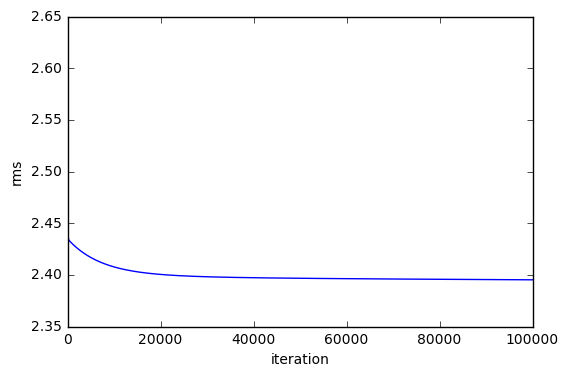

Gradient Desent ||Norm||= 1.5  RMS: 3.8767587135713364


In [8]:

def mainClosedFormSol(dataset):
    
    tdsPhi=dataset[0];
    tdsY=dataset[1];
    vdsPhi=dataset[2];
    vdsY=dataset[3];
    ttds=dataset[4];
    #--------------------[Closed Form Sol without Regularlization]--------------------------------
    #Find w*
    wStar=trainUsingClosedFormEquation(tdsPhi,tdsY);
    #Predict y* for Validate Data
    ystar=pridict(vdsPhi,wStar);
    #checking for RMS for Validate Data
    rms=getRMS(vdsY,ystar);
    #Predict y* for TestData
    ystar=pridict(ttds,wStar);
    writeTestData(ystar);
    print("Closed Form Solution RMS:",rms);
    #---------------------------------------------------------------------------------------------
    pass;


def mainRidgeClosedFormSol(dataset,lam):
    #-------------------------------------
    # Best value: m=300 validate=120
    #-------------------------------------    
    tdsPhi=dataset[0];
    tdsY=dataset[1];
    vdsPhi=dataset[2];
    vdsY=dataset[3];
    ttds=dataset[4];
    #--------------------[Closed Form Sol without Regularlization]--------------------------------
    #Find w*
    wStar=trainUsingClosedFormRidgeEq(tdsPhi,tdsY,lam=lam);
    print(wStar);
    ystar=pridict(tdsPhi,wStar);
    rms=getRMS(tdsY,ystar);
    print("Closed FormSol With Trained Data Ridge RMS ",rms);
    
    #Predict y* for Validate Data
    ystar=pridict(vdsPhi,wStar);
    #checking for RMS for Validate Data
    rms=getRMS(vdsY,ystar);
    #Predict y* for TestData
    ystar=pridict(ttds,wStar);
    writeTestData(ystar);
    print("Closed FormSol With validate Ridge RMS:",rms);
    #---------------------------------------------------------------------------------------------
    pass;

def mainGradientDesent(dataset,lamdaVal=0.0001,alphaVal=0.0003,maxIter=100000,algFixedIter=True):
    tdsPhi=dataset[0];
    tdsY=dataset[1];
    vdsPhi=dataset[2];
    vdsY=dataset[3];
    ttds=dataset[4];
    #--------------------[Gradient decent with Regularlization]--------------------------------
    wStar=gardientDescentWithRidge(tdsPhi,tdsY,maxIteration=maxIter,algFixedIteration=algFixedIter,lam=lamdaVal,alpha=alphaVal);
    #Predict y* for Validate Data
    ystar=pridict(vdsPhi,wStar);
    #checking for RMS for Validate Data
    rms=getRMS(vdsY,ystar);
    #Predict y* for TestData
    ystar=pridict(ttds,wStar);
    writeTestData(ystar);
    print("Gradient Desent ||Norm||=2 RMS:",rms);
    #---------------------------------------------------------------------------------------------

def mainGradientDesentLpnorm(dataset,pnorm,lamdaVal=0.0001,alphaVal=0.0003,maxIter=100000,algFixedIter=True):
    tdsPhi=dataset[0];
    tdsY=dataset[1];
    vdsPhi=dataset[2];
    vdsY=dataset[3];
    ttds=dataset[4];
    #--------------------[Gradient decent with Regularlization]--------------------------------
    wStar=gardientDescentWithPnom(tdsPhi,tdsY,pnorm,maxIteration=maxIter,algFixedIteration=algFixedIter,lam=lamdaVal,alpha=alphaVal);
    #Predict y* for Validate Data
    ystar=pridict(vdsPhi,wStar);
    #checking for RMS for Validate Data
    rms=getRMS(vdsY,ystar);
    #Predict y* for TestData
    ystar=pridict(ttds,wStar);
    writeTestData(ystar);
    print("Gradient Desent ||Norm||=",pnorm," RMS:",rms);
    #---------------------------------------------------------------------------------------------

    
    
#split train data into Train and Validate
def spitTrainDataset(phi,y,tdSize=300):
    m=len(phi);        
    tdsSize=int(m*trainDSSizePercentage);
    l=tdSize;    
    trainDatasetPhi=phi[0:l];
    trainDatasetY=y[0:l];
    validateDatasetPhi=phi[tdsSize:m];
    validateDatasetY=y[tdsSize:m];    
   
    return [trainDatasetPhi,trainDatasetY,validateDatasetPhi,validateDatasetY];    
    pass

def getRoughNewAlpha(currentAlpha,currentRMS,oldRMS,iteration):
    newAlpha=currentAlpha;
    rate=10;
    if(currentAlpha<1):
        if(iteration%100==0 and currentRMS>=100):
            #decrease the learning rate
            newAlpha=newAlpha/rate;
        elif(iteration%100==0 and currentRMS<=100):
            #increase the learning rate
            newAlpha=newAlpha*rate;            
    return newAlpha;
    pass;

def costFunction(phi,y,w,lamda):
    phi=np.array(phi);
    y=np.array(y);
    w=np.array(w);
    phiW=np.dot(phi,w);
    phiWminusY=phiW-y;
    phiWminusYSq=np.power(np.linalg.norm(phiWminusY),2);
    wSq=np.power(np.linalg.norm(w),2);
    cost=phiWminusYSq+(lamda*wSq);
    return cost;
    pass;

def gardientCostFunction(phi,y,w,lamda):
    phi=np.array(phi);
    y=(np.array(y));#converting row vector to col vector    
    phiT=np.transpose(phi);
    phiTphi=np.dot(phiT,phi);   
    phiTy=np.dot(phiT,y);   
    wDash=(np.dot(phiTphi,w)-phiTy)+(lamda*w);   
    return wDash;
    pass;

def getNewAlphaByBacktrack(phi,y,w,lamda):
    #f(x − deltaf(x))    
    beta=0.2;    
    t=1;    
    while(True):
        gw=gardientCostFunction(phi,y,w,lamda);
        y1=costFunction(phi,y,(w-gw),lamda);
        y3=costFunction(phi,y,w,lamda);
        y4=np.power(np.linalg.norm(gw),2);
        y2=y3-(t*0.5*y4);
        print("t=",t," y1=",y1," y2=",y2," y3=",y3," y4=",y4);
        if(y1<=y2):
            break;
        t=beta*t;
    print("T==",t);
    return t;
    pass;
 
# GD: Least Sq. With Ridges
def gardientDescentWithRidge(phi,y,lam,alpha,wi=-1,maxIteration=100000,algFixedIteration=True):
    m=len(y);#no of data points
    n=len(phi[0]);# no. of features    
    #alpha=.000000000003; #learning parameter
    #maxIteration=100000;
    phi=np.array(phi);
    y=(np.array(y));#converting row vector to col vector    
    if(wi==-1):
        wk0=np.zeros(n);# Nx1 vector
    else:
        wk0=phi[wi]
    #.................................................................................
    # Re-intilatinzing w0 after interration for fast convergence. As with un normalized datas it takes many hours
    # to converge. Below are the hours
    #1. Iteration completed: approx 10^7 Note: closed in between as taking too many hours
    #No of Features: 122. #9
    #wk0=[0.00000024,  0.00000012,  0.0000102 , -0.00000061,  0.00000011,  0.00000011,  0.00000255,  0.00000992,  0.00000046,  0.00000182,  0.00004097,  0.00000237,  0.00001784, -0.00000492,  0.00001923,  0.00059716, -0.0000254 ,  0.00000011,  0.00000005,  0.00002387,  0.0004208 ,  0.00000008,  0.00001407,  0.00000225,  0.00001286,  0.00005349, -0.00015837,  0.00000013,  0.00000154,  0.00000016,  0.00000011,  0.00000016,  0.0000008 ,  0.0000015 ,  0.00000034,  0.00000066,  0.00000325,  0.00000077,  0.00000189, -0.0000004 ,  0.00000017,  0.00000062,  0.00000023,  0.00000011,  0.00000019,  0.00000044,  0.00000059,  0.00000029,  0.0000004 ,  0.00000088,  0.00000043,  0.00000064,  0.00000009,  0.0000002,  0.0000004 ,  0.00000024,  0.00000011,  0.00000021,  0.00000032,  0.00000037,  0.00000026,  0.00000031,  0.00000046,  0.00000032,  0.00000038,  0.00000019,  0.00000021,  0.00000032,  0.00000024,  0.00000011,  0.00000022,  0.00000028,  0.0000003 ,  0.00000025,  0.00000027,  0.00000033,  0.00000027,  0.0000003,  0.00000022,  0.00000022,  0.00000029,  0.00000024,  0.00000011,  0.00000023,  0.00000025,  0.00000026,  0.00000024,  0.00000025,  0.00000028,  0.00000025,  0.00000026,  0.00000023,  0.00000103,  0.00000044, -0.00000009,  0.00000208,  0.00000516,  0.00000017,  0.00001691,  0.00000044, -0.00000017,  0.00002003, -0.00001763, -0.00000042,  0.00000008,  0.00000029,  0.00000091,  0.00000007,  0.00000018,  0.00002817,  0.0000021 ,  0.00001942, -0.0000175 , -0.00002501, -0.00034786, -0.00009305,  0.00000288,  0.00002624, -0.00000867, -0.0000018,  0.00005376, -0.00024956];
    #2. Iteration completed: approx 30^7
    #No of Features: 122. #9
    #wk0=[0.00000228,  0.00000166,  0.0000588 , -0.00000667,  0.00000112,  0.00000105 , 0.00002484,  0.00007256,  0.00000481,  0.00002081,  0.00038317,  0.00002285 , 0.00017698, -0.00004922,  0.00016757,  0.00169232, -0.00028316,  0.00000112 , 0.00000046,  0.00023441,  0.00079649,  0.00000846,  0.00020069,  0.00000013 , 0.0001202 ,  0.00001994, -0.00150773,  0.00000141,  0.00001167,  0.00000154 , 0.00000112,  0.00000155,  0.00000773,  0.00001297,  0.00000335,  0.000007 , 0.00003096,  0.00000745,  0.00001856, -0.00000423,  0.00000174,  0.00000525 , 0.00000224,  0.00000112,  0.00000188,  0.00000423,  0.00000542,  0.00000277 , 0.00000404,  0.00000846,  0.00000414,  0.00000621,  0.00000075,  0.00000197 , 0.00000353,  0.00000231,  0.00000112,  0.00000207,  0.00000311,  0.0000035 , 0.00000251,  0.00000304,  0.0000044 ,  0.00000308,  0.0000037 ,  0.00000177 , 0.00000211,  0.00000289,  0.0000023 ,  0.00000112,  0.00000217,  0.00000267 , 0.00000283,  0.00000239,  0.00000263,  0.00000317,  0.00000264,  0.00000289 , 0.00000208,  0.00000218,  0.00000262,  0.00000229,  0.00000112,  0.00000222 , 0.00000246,  0.00000253,  0.00000233,  0.00000245,  0.00000269,  0.00000245 , 0.00000256,  0.00000219,  0.00001796,  0.00000484, -0.00000063,  0.00002088 , 0.00006706,  0.00000127,  0.00030351,  0.00000484, -0.00000153,  0.00018922 ,-0.00002858, -0.00000523,  0.00000083,  0.00000306,  0.00000947,  0.00000074 , 0.00000186,  0.00026123,  0.00003142,  0.00030906, -0.00016762, -0.00005072 ,-0.00060271, -0.00081242,  0.00002939,  0.00026672, -0.00008577,  0.00002142 , 0.0000694 , -0.00239048]
    #3. Iteration completed: 10^8 Note: closed in between as taking too much time   
    #No of Features: 122. #9
    #wk0=[ 0.00000429,  0.00000303,  0.00009374, -0.00001128,  0.0000021 ,  0.000002 , 0.00004604,  0.00013154,  0.00000918,  0.00003969,  0.00071764,  0.00004357 , 0.00033577, -0.0000826 ,  0.00016853,  0.0016491 , -0.00052001,  0.0000021 , 0.00000089,  0.00043243,  0.00090792,  0.00001753,  0.00039021, -0.0000005 , 0.000243  ,  0.00002083, -0.00245923,  0.00000285,  0.00002031,  0.0000032 , 0.0000021 ,  0.00000294,  0.00001441,  0.00002406,  0.00000633,  0.00001328 , 0.00005819,  0.0000141 ,  0.00003515, -0.0000067 ,  0.00000338,  0.00000939 , 0.00000432,  0.0000021 ,  0.00000355,  0.00000792,  0.00001013,  0.00000522 , 0.00000763,  0.00001592,  0.00000782,  0.00001174,  0.00000173,  0.00000377 , 0.00000638,  0.00000439,  0.0000021 ,  0.0000039 ,  0.00000584,  0.00000658 , 0.00000473,  0.00000574,  0.00000828,  0.00000581,  0.00000699,  0.00000345 , 0.00000401,  0.00000525,  0.00000435,  0.0000021 ,  0.00000409,  0.00000502 , 0.00000532,  0.0000045 ,  0.00000496,  0.00000597,  0.00000498,  0.00000545 , 0.00000397,  0.00000413,  0.00000477,  0.00000433,  0.0000021 ,  0.00000419 , 0.00000463,  0.00000477,  0.00000439,  0.00000462,  0.00000506,  0.00000462 , 0.00000483,  0.00000415,  0.00003196,  0.00000905, -0.00000106,  0.00003276 , 0.00012011,  0.00000159,  0.00053434,  0.00000905, -0.00000267,  0.00028351 ,-0.00003651, -0.00001183,  0.00000155,  0.00000575,  0.00001774,  0.00000138 , 0.00000346,  0.00042074,  0.00006398,  0.00062391, -0.0002836 , -0.00004993 ,-0.00059305, -0.00137195,  0.00005671,  0.00050825, -0.00014477,  0.00007982 , 0.00006566, -0.00391314]
    #4. Iteration completed: approx 10^9 Note: closed in between as taking too much time       
    #No of Features: 122. #9
    #wk0=[0.00004052,  0.00002065,  0.00069759, -0.0000394 ,  0.00001962,  0.00001968 , 0.00040321,  0.0011131 ,  0.00008939,  0.00034313,  0.00663027,  0.00041162 , 0.00312193, -0.00028812, -0.0023957 ,  0.00140897, -0.00346996,  0.00001962 , 0.00000968,  0.0036987 ,  0.00112531,  0.00018129,  0.00298163, -0.00001466 , 0.002241  ,  0.00005348, -0.00486676,  0.00003018,  0.0001699 ,  0.00004229 , 0.00001962,  0.00002819,  0.00012959,  0.00021572,  0.00006005,  0.00012034 , 0.00054421,  0.00013331,  0.00032923, -0.00000214,  0.0000337 ,  0.00008128 , 0.00004461,  0.00001962,  0.00003378,  0.00007276,  0.00009321,  0.00004923 , 0.00007059,  0.00014967,  0.00007393,  0.00011056,  0.00003193,  0.00003653 , 0.00005598,  0.00004297,  0.00001962,  0.00003699,  0.00005436,  0.00006136 , 0.00004463,  0.00005368,  0.00007801,  0.00005482,  0.00006592,  0.00003824 , 0.00003835,  0.00004641,  0.00004181,  0.00001962,  0.00003871,  0.00004696 , 0.00004985,  0.00004251,  0.00004668,  0.00005625,  0.00004713,  0.00005145 , 0.0000398 ,  0.00003937,  0.00004226,  0.00004119,  0.00001962,  0.00003961 , 0.00004361,  0.00004493,  0.0000415 ,  0.00004351,  0.00004774,  0.0000437 , 0.0000456 ,  0.00004025,  0.000164  ,  0.00007975, -0.00000602,  0.00004818 , 0.00073583, -0.00003249,  0.00257965,  0.00007975, -0.00001627, -0.00006224 ,-0.00009306, -0.00025038,  0.00001433,  0.00005328,  0.00016427,  0.00001233 , 0.00003093,  0.00062573,  0.00062125,  0.00668248, -0.00113086, -0.00049438 ,-0.00063504, -0.005849  ,  0.00053172,  0.00476664, -0.00054677,  0.00043788 , 0.00000347, -0.00788869]
    #5. Iteration completed: approx 10^11 Note: closed in between as taking too much time       
    #No of Features: 122. #9
    wk0=[42.8612625  ,  -1.14046757 ,  -1.06252978 ,   0.46944066 ,  -5.60391846 , -70.3726374  ,  80.96000485 ,   1.46490995 , -21.7970572  ,   8.78716327 ,   0.55415016 , -10.34289432 ,   0.31692929 ,  -7.5507631  ,   0.00550376 ,   0.00257729 ,  -0.01818881 ,  -5.63320282 ,  28.32398072 ,  -0.61417676 ,  -0.00260213 ,   0.64126723 ,  -0.09233672 ,  -0.00019618 ,   0.26894577 ,  -0.00044879 ,   0.05783857 ,  -1.72766649 ,  25.18052798 ,  10.13240115 ,  -5.66807777 ,  -3.16682888 ,-294.52215742 , -34.4466717  , 158.72466719 , -71.68585093 , -17.36430966 ,  48.96856689 , -12.49998749 ,  12.72021565 ,  -6.23757794 , -74.29890105 , -43.93825806 ,  -5.66794087 ,  32.83971965 ,-141.54238961 ,  61.41514829 ,-159.23631207 ,  65.81724008 ,   3.99525975 ,  51.39600836 ,  73.98036484 , -54.17796862 ,  21.61591299 , -12.43479129 ,  -3.54078479 ,  -5.66893607 ,  43.47934744 , -47.22248303 ,  58.00643945 ,-142.24547841 ,  75.4571528  ,  30.84068789 ,  48.82509585 , -63.79548858 , -12.0651105  ,  -5.94995138 ,  26.46394656 ,  21.61376516 ,  -5.6684142 ,  45.56536849 ,  -0.44191492 ,  51.7966019  , -71.45755854 ,  64.80971002 ,  39.54059307 ,  46.97318198 , -53.47229276 ,  16.13392281 ,   0.33558013 ,  46.16207529 ,  33.71502413 ,  -5.6684142  ,  45.59435143 ,  22.44114991 ,  48.336994   , -19.12355243 ,  55.9343373  ,  42.60482153 ,  45.94498624 , -16.66883355 ,  30.60821494 ,  -0.00972615 ,   0.72039779 , -16.94477838 ,   1.26481702 ,   0.0464093  ,  -0.65534518 ,   0.00675854 ,   0.7203978 ,  12.50531302 ,  -0.12152569 ,  -0.00027075 ,   0.17945797 ,  90.85927153 ,   2.13092033 ,  -1.22866057 , -57.09407799 ,   8.47001552 ,  -0.00176077 ,   3.40268353 ,  -0.07203281 ,  -1.95184606 ,  -0.10104856 ,   0.00181168 ,   0.04610832 ,  -9.30557176 ,   0.06615403 ,   7.41262044 ,  -0.02141117 ,   0.00021472 ,  -0.03124094]
    wk0=np.array(wk0);
    phiT=np.transpose(phi);
    phiTphi=np.dot(phiT,phi);   
    phiTy=np.dot(phiT,y);   
    alphaBym=alpha;
    xaxis=list();
    yaxis=list();
    #algFixedIteration=True;
    logReading=True;
    diff=0;
    #-----------------------------------------------------------------
    #Best Tested Constant
    #1)With 13 features i.e original Phi
    #normalize phi: true.
    #aplha=.212 lamda=.301 tds=300 vds=120 trained o/p=4.8310 rms
    #Note: Tried for different initial wk0 from phi matrix but o/p remain same
    #
    #2)With 26 features i.e newphi=phi + phi^2
    #normalize phi: true; algFixedIteration=True; maxIteration=1000000;
    #aplha=.0003 lamda=.301 tds=300 vds=120 trained o/p=3.940800315632070 rms
    #Tried for different initial wk0 but o/p remain same
    #-----------------------------------------------------------------
    print("Training Started (Least Sq. With Ridge) ...");
    oldRms=0;
    currentAlpha=alphaBym;
    if (algFixedIteration):
        for iteration in range(0,maxIteration):  
            wk1=wk0-(currentAlpha*((np.dot(phiTphi,wk0)-phiTy)+(lam*wk0)));              
            ystar=pridict(phi,wk1);
            rms=getRMS(y,ystar);    
            xaxis.append(iteration);
            yaxis.append(rms);
            percentComplete=((iteration+1)*100)/maxIteration;
            if(percentComplete%10==0 ):
                print("#alpha",currentAlpha,"Percent Completed",percentComplete,"rms:",rms);                
            wk0=wk1;    
            oldRms=rms;
    else:
        diffOffset=1e-12;
        iteration=0;
        oldRms=0;
        voldRms=0;
        while (True):
            wk1=wk0-(alphaBym*((np.dot(phiTphi,wk0)-phiTy)+(lam*wk0)));                     
            ystar=pridict(phi,wk1);
            rms=getRMS(y,ystar);    
            xaxis.append(iteration);
            yaxis.append(rms);
            diff=abs(oldRms-rms);            
            if(iteration>0 and diff<diffOffset):
                break;
            if(False and iteration%100==0 ):
                print("# iteration: ",iteration," rms:",rms,"diff:",diff);            
            if(iteration%100000==0):
                print(wk1);
            wk0=wk1;
            oldRms=rms;
            iteration+=1;
        print("# iteration: ",iteration," rms:",rms,"diff:",diff);    
           
    print("Final Trained RMS:",rms ,". Iteration needed ", iteration);    
    #-------------------------------------------------------------
    if(logReading):
        writeReadingInFile("ridge1.csv",alpha,lam,iteration,rms,2);
    plotGraph(xaxis,yaxis);
    print(wk1);
    return wk1;


# GD: Least Sq. With ||w||_(1.5)^(1.5)
def gardientDescentWithPnom(phi,y,p,lam,alpha,maxIteration=100000,algFixedIteration=True):
    m=len(y);#no of data points
    n=len(phi[0]);# no. of features    
    #alpha=0.0003 #learning parameter
    #maxIteration=1000000;
    phi=np.array(phi);
    y=(np.array(y));#converting row vector to col vector    
    wk0=np.zeros(n);# Nx1 vector    
    #wk0=phi[1];
    #Taken from L2 norm values
    #5. Iteration completed: approx 10^11 Note: closed in between as taking too much time       
    #No of Features: 122. #9
    wk0=[42.8612625  ,  -1.14046757 ,  -1.06252978 ,   0.46944066 ,  -5.60391846 , -70.3726374  ,  80.96000485 ,   1.46490995 , -21.7970572  ,   8.78716327 ,   0.55415016 , -10.34289432 ,   0.31692929 ,  -7.5507631  ,   0.00550376 ,   0.00257729 ,  -0.01818881 ,  -5.63320282 ,  28.32398072 ,  -0.61417676 ,  -0.00260213 ,   0.64126723 ,  -0.09233672 ,  -0.00019618 ,   0.26894577 ,  -0.00044879 ,   0.05783857 ,  -1.72766649 ,  25.18052798 ,  10.13240115 ,  -5.66807777 ,  -3.16682888 ,-294.52215742 , -34.4466717  , 158.72466719 , -71.68585093 , -17.36430966 ,  48.96856689 , -12.49998749 ,  12.72021565 ,  -6.23757794 , -74.29890105 , -43.93825806 ,  -5.66794087 ,  32.83971965 ,-141.54238961 ,  61.41514829 ,-159.23631207 ,  65.81724008 ,   3.99525975 ,  51.39600836 ,  73.98036484 , -54.17796862 ,  21.61591299 , -12.43479129 ,  -3.54078479 ,  -5.66893607 ,  43.47934744 , -47.22248303 ,  58.00643945 ,-142.24547841 ,  75.4571528  ,  30.84068789 ,  48.82509585 , -63.79548858 , -12.0651105  ,  -5.94995138 ,  26.46394656 ,  21.61376516 ,  -5.6684142 ,  45.56536849 ,  -0.44191492 ,  51.7966019  , -71.45755854 ,  64.80971002 ,  39.54059307 ,  46.97318198 , -53.47229276 ,  16.13392281 ,   0.33558013 ,  46.16207529 ,  33.71502413 ,  -5.6684142  ,  45.59435143 ,  22.44114991 ,  48.336994   , -19.12355243 ,  55.9343373  ,  42.60482153 ,  45.94498624 , -16.66883355 ,  30.60821494 ,  -0.00972615 ,   0.72039779 , -16.94477838 ,   1.26481702 ,   0.0464093  ,  -0.65534518 ,   0.00675854 ,   0.7203978 ,  12.50531302 ,  -0.12152569 ,  -0.00027075 ,   0.17945797 ,  90.85927153 ,   2.13092033 ,  -1.22866057 , -57.09407799 ,   8.47001552 ,  -0.00176077 ,   3.40268353 ,  -0.07203281 ,  -1.95184606 ,  -0.10104856 ,   0.00181168 ,   0.04610832 ,  -9.30557176 ,   0.06615403 ,   7.41262044 ,  -0.02141117 ,   0.00021472 ,  -0.03124094]
    wk0=np.array(wk0);    
    phiT=np.transpose(phi);
    phiTphi=np.dot(phiT,phi);   
    phiTy=np.dot(phiT,y);   
    alphaBym=alpha/m;
    #lam=0.31;
    xaxis=list();
    yaxis=list();
    #algFixedIteration=True;
    logReading=True;
    diff=0;
    wPow=p-1;
    if (p<=1):
        print("Error: norm p is less than 1 i.p p=",wPow);
        return None;
        
    #-----------------------------------------------------------------
    print("Training Started (Least Sq. With Ridge) ...");
    if (algFixedIteration):
        for iteration in range(0,maxIteration):
            if (wPow>1):
                wk0Pow=np.power(wk0,wPow);            
            else:
                wk0Pow=wk0;
            wk1=wk0-(alphaBym*((np.dot(phiTphi,wk0)-phiTy)+(lam*wk0Pow))); 
            
            ystar=pridict(phi,wk1);
            rms=getRMS(y,ystar);    
            xaxis.append(iteration);
            yaxis.append(rms);
            percentComplete=((iteration+1)*100)/maxIteration;
            if( percentComplete%10==0 ):
                print("Percent Completed",percentComplete," rms:",rms);
            wk0=wk1;
    else:
        diffOffset=1e-20;
        iteration=0;
        oldRms=0;
        voldRms=0;
        while (True):            
            if (wPow>1):
                wk0Pow=np.power(wk0,wPow);            
            else:
                wk0Pow=wk0;
            wk1=wk0-(alphaBym*((np.dot(phiTphi,wk0)-phiTy)+(lam*wk0Pow)));  
            ystar=pridict(phi,wk1);
            rms=getRMS(y,ystar);    
            xaxis.append(iteration);
            yaxis.append(rms);
            diff=abs(oldRms-rms);                      
            
            if(iteration>0 and  diff<=diffOffset):
                break;
            if(False and iteration%100==0 ):
                print("# iteration: ",iteration," rms:",rms,"diff:",diff);            
            wk0=wk1;
            oldRms=rms;            
            iteration+=1;
        print("# iteration: ",iteration," rms:",rms,"diff:",diff);    

    print("Final Trained RMS:",rms ,". Iteration needed ", iteration);       
    #-------------------------------------------------------------
    if(logReading):
        writeReadingInFile("pnom.csv",alpha,lam,iteration,rms,p);
    plotGraph(xaxis,yaxis);
    return wk1; 

# Finding w*=(QTQ+lamI)^-1QTY
def trainUsingClosedFormRidgeEq(dataset,output,lam=0.0001):
    #-------------------------------------
    # 1)Best value: m=300 validate=120
    # addW0=True: c=0.376654. Not lamd
    # Note: Please make eq as phiT_phi+c
    #
    # 2)Best value: m=300 validate=120
    # addW0=True: lam=0.521. Not C. 
    # trained RMS:  3.938231279881311
    # Note: Please make eq as phiT_phi+lamI
    #-------------------------------------
    m=len(dataset);
    n=len(dataset[0]);    
    phi=np.array(dataset);
    y=np.array(output);
    phiT=np.transpose(phi);    
    #(QTQ)    
    phiT_phi=np.dot(phiT,phi);
    n=len(phiT_phi);    
    c=.301;
    I=np.identity(n);
    lamI=lam*I;
    d=getDet(phiT_phi)
    #--------------------------------------
    if(True or d>0):
        #(QTQ+lamI)^-1
        phiT_phi_inv=inv((phiT_phi+lamI));
        #(QTQ+lamI)^-1QT
        phiT_phi_inv_phiT=np.dot(phiT_phi_inv,phiT);  
        #(QTQ+lamI)^-1QT*Y
        w=np.dot(phiT_phi_inv_phiT,y);
        return w;
    else:
        print("Error:Phi is NOT full column rank.");
        return None;
    pass;



def getKernalFeature(phi,wrtdataPoint):    
    p=np.array(phi);           
    wrtdata=np.array(phiSet[wrtdataPoint]);     
    tempMatrix=p-wrtdata;    
    fcol=np.sum(tempMatrix,axis=1);
    sigma=2;
    fcol=np.power(fcol,2);
    fcol=fcol*(-1*(1/sigma));
    fcol=np.exp(fcol);    
    return fcol;
    pass;


def createNewFeatureMatrix(phi,maxDeg=4):    
    newPhi=np.array(phi);
    p=np.array(phi);        
    if(addW0Col):#deleting first W0Col coffecient is 1
        p=np.delete(p,0,1);    

    TotalColumn=len(p[0]);
    HalfColumn=int(len(p[0])/2)+1;  
    
    #---------------------------------------------------------------------------------
    #Best Features till now.
    #1. feature sq2 with lamda 0.001
    #2. feature sq2 + sq root with lamda 0.001
    #3. feature sq2 + 1/2 root + 1/4 root with lamda 0.001 rms: 3.02849
    #
    #4. feature sq2 + 1/2 root + 1/4 root + 1/8 + 1/16  + 1/32 lamda=0.0001
    #
    #5. feature sq2 + 1/2 root + 1/4 root + 1/8 + 1/16 +  + 1/32 [x0.x1 x0.x2 x0.x3....x0.x7] lamda=0.0001
    #
    #6. feature sq2 + 1/2 root + 1/4 root + 1/8 + 1/16 +  + 1/32 [x0.x1 x0.x2 ....x0.x7]+ [x0.x1^2 x0.x2^2 ..x0.x7^2] lamda=0.0001
    #   train rms= 2.732538945291264 validate Rms=4.711844963854281 test RMS=3.014
    #
    #7. feature sq2 + 1/2 root + 1/4 root + 1/8 + 1/16 +  + 1/32 [x0.x1 x0.x2 ....] +[x0.x1^2 x0.x2^2...x0.x7^2] 
    #   [x3.x4^0.05 x3.x5^0.05]
    #   lamda=0.0001 train rms= 2.6523470519008407 validate Rms=4.490001110608855 test RMS=2.85636\
    #
    #8. feature sq2 + 1/2 root + 1/4 root + 1/8 + 1/16 +  + 1/32 [x0.x1 x0.x1 ....x0.x7] +[x0.x1^2 x0.x2^2..x0.x7^2] 
    #   + [x3.x4^0.5 x3.x5^0.5 .... x3.x7^0.5]
    #
    #9. feature sq2 + 1/2 root + 1/4 root + 1/8 + 1/16 +  + 1/32 [x0.x1 x0.x1 ....x0.x7] +[x0.x1^2 x0.x2^2..x0.x7^2] 
    #   + [x3.x4^0.5 x3.x5^0.5...x3.x7^0.5] + [x3.x4^2.x5^0.4 x3.x4^2.x6^0.4 x3.x4^2.x7^0.4]     
    #   lamda=0.0001 train rms=2.6147993385918764 validate Rms=2.6147993385918764 test rms=2.7
    #
    #10. feature sq2 + 1/2 root + 1/4 root + 1/8 + 1/16 + 1/32 [x0.x1 x0.x1 ...x0.x7] +[x0.x1^2 x0.x2^2 ...x0.x7^2] 
    #   + [x3.x4^0.5 x3.x5^0.5 ... x3.x7^0.5] + [x3.x4^2.x5^0.4 x3.x4^2.x6^0.4 x3.x4^2.x7^0.4]     
    #   + [x7.x10 .... x7.x13]
    #   lamda=0.0001 train rms=2.5057404497731555 validate Rms=4.230169910269796 test rms=2.55676    
    #
    #11. feature sq2 + 1/2 root + 1/4 root + 1/8 + 1/16 + 1/32 [x0.x1 x0.x1 ...x0.x7] +[x0.x1^2 x0.x2^2 ...x0.x7^2] 
    #   + [x3.x4^0.5 x3.x5^0.5 ... x3.x7^0.5] + [x3.x4^2.x5^0.4 x3.x4^2.x6^0.4 x3.x4^2.x7^0.4]     
    #   + [x7.x10 .... x7.x13] + [x7.x10^2 .... x7.x13^2] + [x7.x10^0.5 .... x7.x13^0.5]
    #   lamda=0.0001 train rms=2.340500337718980 validate Rms=3.8389206328449315 test rms=2.35368    
    # 
    #--------------------------------------------------------------------------------------------
   
    absP=np.abs(p)
    pPowI=np.power(p,2);        
    newPhi=np.concatenate((newPhi,pPowI),axis=1);     
        
    pPowI=np.power(absP,0.5);        
    newPhi=np.concatenate((newPhi,pPowI),axis=1); 
        
    pPowI=np.power(absP,0.25);        
    newPhi=np.concatenate((newPhi,pPowI),axis=1); 
   
    pPowI=np.power(absP,0.125);        
    newPhi=np.concatenate((newPhi,pPowI),axis=1); 
       
    pPowI=np.power(absP,0.0625);        
    newPhi=np.concatenate((newPhi,pPowI),axis=1); 
        
    pPowI=np.power(absP,0.03125);        
    newPhi=np.concatenate((newPhi,pPowI),axis=1); 
 
    c1=p[:,0];        
    for i in range(1,HalfColumn):
        c2=p[:,i+1];
        c3=c1*c2;
        newPhi=np.insert(newPhi,len(newPhi[0]),c3,axis=1);    
    
    
    c1=p[:,0];            
    pPowI=np.power(p,2);                
    for i in range(1,HalfColumn):
        c2=pPowI[:,i+1];
        c3=c1*c2;
        newPhi=np.insert(newPhi,len(newPhi[0]),c3,axis=1);    
    
    
    c1=p[:,3];                
    pPowI=np.power(absP,0.5);                
    for i in range(4,HalfColumn):
        c2=pPowI[:,i];
        c3=c1*c2;
        newPhi=np.insert(newPhi,len(newPhi[0]),c3,axis=1);    
    
    c1=p[:,3];      
    c2=p[:,4]**2;
    n=int(len(p[0])/2)+1;                    
    pPowI=np.power(absP,0.4);                
    for i in range(5,HalfColumn):
        c3=pPowI[:,i];
        c=c1*c2*c3;
        newPhi=np.insert(newPhi,len(newPhi[0]),c,axis=1);    
    
    n=int(len(p[0])/2)+1;                 
    c1=p[:,7];      
    for i in range(9,TotalColumn):
        c3=p[:,i];
        c=c3*c1;
        newPhi=np.insert(newPhi,len(newPhi[0]),c,axis=1);    
       
    c1=np.abs(p[:,7])**2;
    for i in range(10,TotalColumn):
        c3=p[:,i];
        c=c3*c1;
        newPhi=np.insert(newPhi,len(newPhi[0]),c,axis=1);    
    
    c1=np.abs(p[:,7])**0.5;
    for i in range(10,TotalColumn):
        c3=p[:,i];
        c=c3*c1;
        newPhi=np.insert(newPhi,len(newPhi[0]),c,axis=1);    
    
    c1=np.abs(p[:,7])**0.5;
    pPowI=np.power(absP,2);                   
    for i in range(10,TotalColumn):
        c3=pPowI[:,i];
        c=c3*c1;
        newPhi=np.insert(newPhi,len(newPhi[0]),c,axis=1);           
    
    return newPhi;    
    pass;

#--settings--
np.set_printoptions(suppress=True)
#---init---
dir=""
trainFile=dir+"train.csv";
testFile=dir+"test.csv";
trainDSSizePercentage=0.7; # x*100 percentage. 1-x data set will be used for validating
addW0Col=True;
tdSize=280;
#---------------------------------------------
print("Fetching Trained Dataset from file...");
dataset=readTrainData(trainFile);
testDS=readTestData(testFile);
phiSet=dataset[0];
ySet=dataset[1];

newPhiSet=createNewFeatureMatrix(phiSet,2);
newTestDS=createNewFeatureMatrix(testDS,2);


phiSet_norm=normalizePhi(newPhiSet);
testDS_norm=normalizePhi(newTestDS);

tds=spitTrainDataset(phiSet,ySet,tdSize);
tds_norm=spitTrainDataset(phiSet_norm,ySet,tdSize);

print("Fetching of data Completed.");

#train set
trainDatasetPhi=tds[0];
trainDatasetY=tds[1];
validateDatasetPhi=tds[2];
validateDatasetY=tds[3];
gtdPhi=trainDatasetPhi;

trainDatasetPhi_norm=tds_norm[0];
trainDatasetY_norm=tds_norm[1];
validateDatasetPhi_norm=tds_norm[2];
validateDatasetY_norm=tds_norm[3];


deg=2;
#trainDatasetPhi_norm=createNewFeatureMatrix(trainDatasetPhi_norm,deg);
#validateDatasetPhi_norm=createNewFeatureMatrix(validateDatasetPhi_norm,deg);
#testDS_norm=createNewFeatureMatrix(testDS_norm,deg);

deg=2;
trainDatasetPhi=createNewFeatureMatrix(trainDatasetPhi,deg);
validateDatasetPhi=createNewFeatureMatrix(validateDatasetPhi,deg);
testDS=createNewFeatureMatrix(testDS,deg);

print("Train Size:"+str(len(trainDatasetPhi)));
print("Validate Size:"+str(len(validateDatasetPhi)));

ds=[trainDatasetPhi,trainDatasetY,validateDatasetPhi,validateDatasetY,testDS];
ds_norm=[trainDatasetPhi_norm,trainDatasetY,validateDatasetPhi_norm,validateDatasetY,testDS_norm];
#mainClosedFormSol(ds);
mainRidgeClosedFormSol(ds,0.0001);
#mainGradientDesent(ds,lamdaVal=0.0001,alphaVal=0.000000000000001,maxIter=1000000);
#mainGradientDesentLpnorm(ds,3/2,lamdaVal=0.0001,alphaVal=0.00000000001,maxIter=100000);

